In [8]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy as sp
import datetime

import matplotlib.pylab as plt
import os
import random
import math

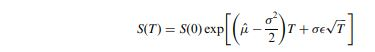

Using the above stochastic equation for an equity, a Monte Carlo simulation function is built considering the correlation of the two hypothetical stocks in the scope for  given level of initial stock prices, volatilities, correlation matrix expected returns, Time, intervals, and number of simulations. Cholesky decomposition is used for getting the correct covariance matrix between the two stocks in scope.

After getting the future paths for next 252 trading days of teh correlated stocks in scope, a portfolio can be constructed with any given weights and then portfolio returns are calculated. Post this step, the portfolio returns are sorted in ascending order and worst portfolio retuns at 5% & 1% cutoff are derived for VaR calculation at 99% & 95% confidence interval.


In [9]:
def return_calc(data_set,l):    # Function to calculate returns and convert it to dataframe
    
    return_A=[]
    return_B=[]

    for r in range(0,l-1):
        ret_A=np.log(data_set[0][r+1]/data_set[0][0])
        ret_B=np.log(data_set[1][r+1]/data_set[1][0])
        return_A.append(ret_A)
        return_B.append(ret_B)

    return pd.DataFrame (list(zip(return_A,return_B)),columns=['A','B'])

In [10]:
#S0_A=data[0][-1]
#S0_B=data[1][-1]
#S0_C=data[2][-1]
#S0_D=data[3][-1]

def Rho_matrix(RhoAB):            #Correlelation matrix
    corr=np.array([[1.0,RhoAB],
                  [RhoAB,1.0]])
    return corr

#correlation=Rho_matrix(0.8)

def MC(ER_A,ER_B,S0_A,S0_B,sigma_A,sigma_B,RhoAB,intervals,sim): # Monte Carlo Simulation of daily paths of stock A & stock B using GBM equation
    
    scenario_A = []  # storing simulated prices of stock A
    scenario_B = []  # storing simulated prices of stock B

    std=np.diag([sigma_A, sigma_B])  #volatility matrix of stock A and stock B
    corr_matrix=Rho_matrix(RhoAB)    #correlation matrix of stock A & stock B
    cov_matrix=np.dot(std,np.dot(std,corr_matrix))      # covariance matrix 
    L = np.linalg.cholesky(np.array(cov_matrix)) # Cholesky decomposition of cov matrix to get bivariate normal distribution
    T=1.0 
    
    for i in range(sim):
        sp.random.seed(12345+i)
        V = L.dot(np.random.normal(0, 1, 2))
        
        ST_A=S0_A*np.exp((ER_A-(sigma_A**2)/2)*(T/intervals)+sigma_A*V[0]*np.sqrt(T/intervals))
        ST_B=S0_B*np.exp((ER_B-(sigma_B**2)/2)*(T/intervals)+sigma_B*V[1]*np.sqrt(T/intervals))
        scenario_A.append(ST_A)
        scenario_B.append(ST_B)
        S0_A=ST_A
        S0_B=ST_B
       
    return [scenario_A,scenario_B]


In [11]:
#correlation=Rho_matrix(0.8)
MC(0.14,0.18,100,110,0.25,0.3,-0.1,252,100) # 100 simulation runs for two stocks A & B

[[99.96256570503803,
  99.97029069256403,
  100.14886571621727,
  100.71001022052394,
  100.41623304651618,
  100.75466980784093,
  100.18998488621324,
  100.49183829171726,
  100.783148734615,
  100.44269561113767,
  99.5900603039023,
  99.90299911062466,
  100.17471006716346,
  100.52066899816317,
  100.18854668858802,
  100.59784586702455,
  100.46945228513249,
  100.95746333329656,
  101.17483104127412,
  101.43069838605555,
  101.31020302331464,
  101.77462708424238,
  101.49782706850037,
  101.61065982767309,
  101.78553889557598,
  102.51375315505999,
  102.38841249912072,
  102.95854126063826,
  103.87944681058765,
  104.12230638834723,
  103.89329827988156,
  103.93740221539146,
  104.00812707791847,
  104.08037840850406,
  104.10417037551443,
  103.30765320819373,
  103.88723843206853,
  104.4096309685107,
  105.07813107108124,
  105.36215649714518,
  105.33102347052515,
  105.0576633821779,
  105.63934161473937,
  105.04008087806395,
  105.91827438371173,
  106.3939682326155

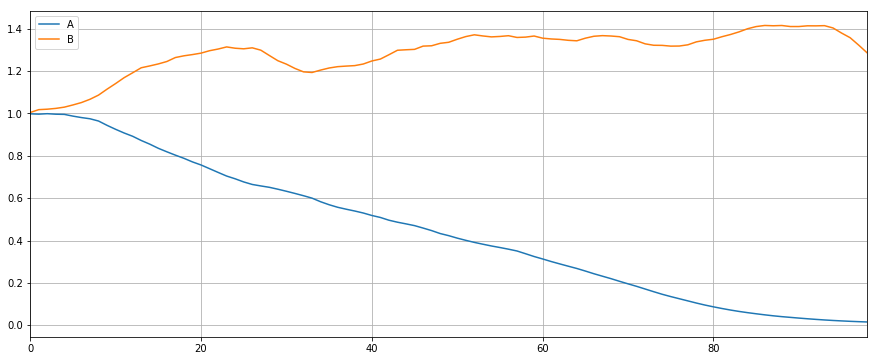

In [12]:
cr=(1+return_calc(MC(-0.3,0.18,100,110,0.25,0.3,-0.4,252,100),100)).cumprod()
plt.rcParams["figure.figsize"] = (15,6)
cr.plot(grid=True)
plt.show()

In [13]:
port=return_calc(MC(-0.3,0.18,100,110,0.25,0.3,-0.4,252,100),100)
w1,w2=0.5,0.5  #portfolio with equal weights 
port['returns']=port['A']*w1+port['B']*w2
port

,A,B,returns
0,-0.001669,0.004557,0.001444
1,-0.001630,0.013351,0.005861
2,0.002211,0.002128,0.002170
3,-0.002456,0.003696,0.000620
4,-0.000837,0.005791,0.002477
5,-0.008204,0.009997,0.000897
6,-0.006941,0.010904,0.001981
7,-0.005793,0.014704,0.004456
8,-0.010923,0.018519,0.003798
9,-0.021194,0.025835,0.002320


In [14]:
port.sort_values(['returns'],inplace=True,ascending=True)
port

,A,B,returns
98,-0.087018,-0.027884,-0.057451
97,-0.087543,-0.025708,-0.056625
96,-0.094762,-0.015880,-0.055321
95,-0.093069,-0.017114,-0.055092
94,-0.095764,-0.007774,-0.051769
92,-0.097131,-0.000125,-0.048628
93,-0.097618,0.000702,-0.048458
87,-0.093392,-0.001002,-0.047197
91,-0.094479,0.002391,-0.046044
90,-0.091621,-0.000008,-0.045815


In [15]:
VaR95=port['returns'].quantile(0.05)
VaR99=port['returns'].quantile(0.01)
print ('VaR95: {:.2%}' .format(VaR95)) #Value at Risk at 95% confidence interval for single day returns
print ('VaR99: {:.2%}' .format(VaR99))

VaR95: -4.89%
VaR99: -5.66%
